# NNIA Assignment 9

**DEADLINE: 26. 1. 2022 08:00 CET**
Submission more than 10 minutes past the deadline will **not** be graded!

- Trevor Atkins & trat00001@uni-saarland.de:
- Tsimafei Prakapenka & tspr00001@uni-saarland.de:
- Hours of work per person: Prakapenka ~2h
- Group nickname:

# Submission Instructions

**IMPORTANT** Please make sure you read the following instructions carefully. If you are unclear about any part of the assignment, ask questions **before** the assignment deadline. All course-related questions can be addressed on the course **[Piazza Platform](https://piazza.com/class/kvc3vzhsvh55rt)**.

* Assignments are to be submitted in a **team of 2**.
* Please include your **names**, **ID's**, **Teams usernames**, and **approximate total time spent per person** at the beginning of the Notebook in the space provided
* Make sure you appropriately comment your code wherever required.
* Your final submission should contain this completed Jupyter Notebook, including the bonus question (if you attempt it), and any necessary Python files.
* Do **not** submit any data or cache files (e.g. `__pycache__`).
* Upload the **zipped** folder (*.zip* is the only accepted extension) in **Teams**.
* Only **one member** of the group should make the submisssion.
* **Important** please name the submitted zip folder as: `Name1_id1_Name2_id2.zip`. The Jupyter Notebook should also be named: `Name1_id1_Name2_id2.ipynb`. This is **very important** for our internal organization epeatedly students fail to do this.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1 Diacritization (9 points)

The English alphabet has 26 letters. This is not the case for Czech (and many more European languages), which has many more extra letters, namely those with a simple accent (čárka, lit. "short line segment"): `áéíýúó`, those with a little hook (háček): `ěčšžř` and those with a circle (kroužek) `ů`.
They change the pronounciations of the words (mostly palatalization) and also distinguish words (there are many words which differ only by diacritics). 
Typing words without these accents is considered to be rude (and annoying to read).
Imagine you've been tasked by a telecommunication company to come up with a system to automatically add all the accents correctly given a word without accents.
Each line in the input contains two words: with and without accents, e.g.: `cerveneho červeného`.
We provide the train/dev split for you (in separate files) and also a test file without correct answers.

Your task is to create two neural networks character-level models that add the diacritization back to the word.

## 1.1 Baseline (1 points)

- Plot the distribution of classes (there are 4)
- Evaluate the accuracy of most common class classifier

In [ ]:
! pip install wget

In [ ]:
import os
import wget

from typing import List, Tuple, Generator, Union
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

In [ ]:
def download_data_files(filenames: List[str]):
    git_data_path = 'https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Neural_Networks/HW9_data/'
    for filename in filenames:
        if not os.path.isfile(filename):
            url = git_data_path + filename
            wget.download(url, filename)

In [ ]:
train_filename = 'words_random_train.txt'
dev_filename = 'words_random_dev.txt'
test_filename = 'words_random_test_blind.txt'

download_data_files([train_filename, dev_filename, test_filename])

In [ ]:
with open(train_filename, "r") as f:
    train_data = list(map(str.split, f.readlines()))

with open(dev_filename, "r") as f:
    dev_data = list(map(str.split, f.readlines()))

with open(test_filename, "r") as f:
    test_data = list(map(str.split, f.readlines()))

print(train_data[1], dev_data[1], test_data[1])

['nájemřidiči', 'najemridici'] ['neodmyslitelné', 'neodmyslitelne'] ['transvestite']


In [ ]:
classlabel_to_classname = {0: 'nothing', 1: 'čárka', 2: 'háček', 3: 'kroužek'}
classlabel_to_char = {1: ['á','é','í','ý','ú','ó'], 2: ['ě','č','š','ž','ř'], 3: ['ů']}

# I use defaultdict to handle 0-class more smoothly
char_to_classlabel = defaultdict(int)
char_to_classlabel.update({
    class_char: class_label 
    for class_label, class_chars in classlabel_to_char.items() 
    for class_char in class_chars
})
print(char_to_classlabel)

defaultdict(<class 'int'>, {'á': 1, 'é': 1, 'í': 1, 'ý': 1, 'ú': 1, 'ó': 1, 'ě': 2, 'č': 2, 'š': 2, 'ž': 2, 'ř': 2, 'ů': 3})


In [ ]:
def distribution():
    accented_words = [row[0] for row in train_data]
    characters = [char for word in accented_words for char in word]

    # dict with char as a key and integer count as value
    char_to_count = Counter(characters)

    # dict with class_label as a key (int) and integer count as value
    classlabel_to_count = {class_label: 0 for class_label in classlabel_to_classname}

    for char, char_count in char_to_count.items():
        # 0 will be returned for non-classified char
        # this default behaviour is handled by defaultclass design
        char_classlabel = char_to_classlabel[char]
        classlabel_to_count[char_classlabel] += char_count

    class_counts = {
        classlabel_to_classname[class_label]: class_count 
        for class_label, class_count in classlabel_to_count.items()
    }
    
    plt.bar(class_counts.keys(), class_counts.values(), 1)
    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    return class_counts

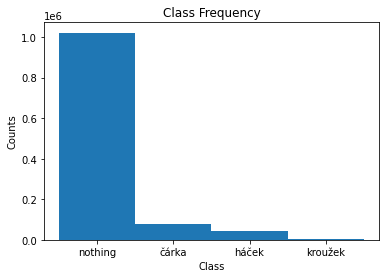

{'nothing': 1021576, 'čárka': 78545, 'háček': 42728, 'kroužek': 2601}
{'nothing': 0.8918556026015976, 'čárka': 0.06857130385438037, 'háček': 0.03730237024750098, 'kroužek': 0.002270723296521018}


In [ ]:
classname_to_count = distribution()
print(classname_to_count)

all_count = sum(classname_to_count.values())
classname_to_percentage = {
    class_name: class_count/all_count 
    for class_name, class_count in classname_to_count.items()
}
print(classname_to_percentage)

So, defaulting to nothing class will give us ~0.89 accuracy. Definitely not bad for a start.

## 1.2 Sliding windows (3 points)

The first model is based on sliding windows, e.g. it considers the current character and two characters to the left and two characters to the right for context.
You should also add padding tokens to the left and to the right so that you can classify the corner characters as well:

```
__Cer -> HOOK
_cErv -> NOTHING
ceRve -> NOTHING
erVen -> NOTHING
rvEne -> NOTHING
veNeh -> NOTHING
enEho -> SIMPLE ACCENT
neHo_ -> NOTHING
ehO__ -> NOTHING
```


Build a sliding-window neural network with the best architecture and hyperparameters and report your accuracies on train and dev datasets.
Additionally, provide the output for the test file.

In [ ]:
PADDING_SYMBOL = '_'
ALPHABET_SIZE = 26

In [ ]:
def prepare_sliding_data(
        data_corpus: List[List[str]],
        padding_symbol: str = PADDING_SYMBOL, window_size: int = 2
) -> Generator[Tuple[str, int], None, None]:
    """
    Returns data in a sliding window format:
    generator of tuples with str as a key and int as a label value.
    """
    for accented_word, unaccented_word in data_corpus:
        assert len(accented_word) == len(unaccented_word)
        word_len = len(accented_word)
        for mid in range(word_len):
            word_slice = []
            # left border is inclusive, right border is exclusive
            l, r = mid - window_size, mid + window_size + 1

            # handle left_part
            if l < 0:
                word_slice.extend(padding_symbol * abs(l))
            else:
                word_slice.extend(unaccented_word[l:mid])

            word_slice.append(unaccented_word[mid])

            if r >= word_len:
                word_slice.extend(padding_symbol * (r - word_len))
            else:
                word_slice.extend(unaccented_word[mid + 1:r])

            word_slice_str = "".join(word_slice)
            class_label = char_to_classlabel[accented_word[mid]]
                
            yield word_slice_str, class_label

In [ ]:
# test function
print(train_data[1:2])
list(prepare_sliding_data(train_data[1:2]))

[['nájemřidiči', 'najemridici']]


[('__naj', 0),
 ('_aje', 1),
 ('najem', 0),
 ('ajemr', 0),
 ('jemri', 0),
 ('emrid', 2),
 ('mridi', 0),
 ('ridic', 0),
 ('idi', 0),
 ('dic_', 2),
 ('ici__', 0)]

In [ ]:
sliding_data_train = prepare_sliding_data(train_data)
sliding_data_dev = prepare_sliding_data(dev_data)
sliding_data_test = prepare_sliding_data(test_data)

In [ ]:
def encode_data(word_slice: Union[Tuple[str, int], str],
                padding_symbol: str = PADDING_SYMBOL) -> List[int]:
    """
    Makes one-hot vectors (a: (1, 0, 0, ..., 0), z: (0, 0, ...., 1).) 
    and concats them. 
    Final size of every input is ALPHABET_SIZE*len(word_slice) (here, 26*5=130).

    Parameters
    ----------
    word_slice : Union[Tuple[str, int], str]
        Word slice in one of the two formats: slice_to_class tuple or raw slice.
    padding_symbol : str
        Padding symbol which will be encoded as zero-vector.

    Returns
    -------
    List[int]
        Vector representation of word_slice.
    """
    res_vector = []
    if isinstance(word_slice, tuple):
        word_slice, _ = word_slice
    for chr in word_slice:
        char_vector = [0]*ALPHABET_SIZE
        if chr != padding_symbol:
            char_vector[ord(chr) - ord('a')] = 1
        res_vector.extend(char_vector)
    
    return res_vector

In [ ]:
train_sample = next(sliding_data_train)
encoded_data = encode_data(train_sample)
print(train_sample, encoded_data[:ALPHABET_SIZE], len(encoded_data))

('ignor', 0) [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 130


## 1.3 RNN (5 points)

Secondly, build a character-level recurrent neural network many (n) to many (n) which performs the classification:
```
cerveny -> HNNNNNANN
```

Be careful, this will require you to either pad the input sequence (then you will also need to backpropagate only from the original sequence and disregard padded values) or use some other trick.

You can use all the tricks you know for both models. For the RNN-based one, you can use non-vanilla RNN cells (such as LSTM or GRU). The recurrent part should be followed-up with a classification FFNN. Again, try to find the best architecture and hyperparameters, report train and dev results.

In both cases, describe in text the architecture of your models.

Provide also an output for the test file, one word per file, with diacritics (e.g. `červeného`). This is mandatory.

In [ ]:
# run pseudo-batching, just count things and them run loss.backward() and optimizer.step(w)

# 2 Theory (1 point)

Find NLP tasks (apart form diacritization) that match the following RNN architecture and describe them in detail:
- Many (n) to many (n)
- Many (n) to many (m), m $\neq$ n
- Many (n) to one


- Many (n) to many (n) - POS-tagging
- Many (n) to many (m), m $\neq$ n - Machine Translation
- Many (n) to one - Sentiment Analysis

# Final remarks

## Accuracies

It is important that your models perform well:

||Dev accuracy|
|-|-|
|Minimum for full points on sliding windows|96.0%|
|Minimum for full points on RNN|97.0%|
|SoTA [Náplava et al. 2021](https://ufal.mff.cuni.cz/pbml/116/art-naplava-straka-strakova.pdf)|99.2% (different dataset)|
|Best student solution from Charles University|99.1% (different dataset)|
|A foreign student living in Prague for 5 years|92.0% (Vilém's personal feeling)|

We will evaluate your test results and top 2 groups will get +2 points.
The next 2 groups will get +1 point.

## Runtime

You don't need to use a GPU.
The training on a 2019 high-end CPU takes 60 minutes.
If you really need more compute power (you shouldn't need to need it) then you can use Google collab.
Nevertheless, we suggest you to first work on a subset of data for a faster development loop.

In [ ]:
! rm $train_filename $dev_filename $test_filename